# Cours d'introduction à la technologie Chipwhisperer 

## *Simple Power Analysis* : partir sur de bonnes bases

Commençons par un rappel sur ce qu'est une *SPA* : il s'agit d'une technique qui consiste à interpréter directement les mesures
de consommation d’énergie recueillies au cours d’opérations cryptographiques, afin de déchiffrer le message. L'attaque se déroule donc en 3 étapes : 
  1. récupérer des traces de consommation électrique
  2. mettre en évidence des variations de consommation 
  3. en déduire des informations sur les opérations cryptographiques réalisées, voire directement sur la clé

Pour commencer, nous présenterons une attaque très simple car réalisée dans des conditions très spéciales : une attaque à texte clair choisi. Autrement dit, nous allons exécuter certaines instructions précises et étudier les traces de consommation obtenues. 
Partons du principe que l'étape 1 a été réalisée, autrement dit que nous disposons d'un échantillon de traces de consommation électrique `traces_test` de taille suffisamment grande capturé à l'aide du chipwhisperer :

In [2]:
from cwtraces import sca101_lab_data
import chipwhisperer as cw
import numpy as np 

cap_pass_trace = sca101_lab_data["lab2_1"]["cap_pass_trace"]

trace_test = cap_pass_trace("h\n") # mot de passe commençant par h

#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

✔️ OK to continue!


Notre objectif est de découvrir le mot de passe à 5 caractères à partir duquel ont été obtenues les traces, et petit coup de pouce : il commence par $h$. 
L'avantage dont nous disposons est que le nombre de possibilités pour le mot de passe est assez réduit : l'ensemble des caractères alphanumériques (on se limitera aux chiffres et lettres pour notre exemple) $x$ le nombre de caractères. Mais comment faire pour valider ou invalider une proposition ? Il nous suffit, dans ce cas très simple, de réaliser une *SPA*. Pour cela, il faut donc appliquer l'étape numéro 2 de notre attaque et mettre en évidence des variations dans les traces de consommation. 

C'est ici que l'on va choisir les textes clairs dont on va analyser les traces de consommation : puisque nous disposons de la trace réalisée par le 'vrai' mot de passe, il nous suffit de la comparer avec celles produites par chaque mot de passe possible jusqu'à observer une concordance : c'est exactement le principe d'une *Power Analysis*. Pour illustrer notre propos, appliquons cette méthode afin de deviner le deuxième caractère du mot de passe. Normalement, une trace devrait se détacher nettement des autres et correspondre ainsi au 'vrai' mot de passe.

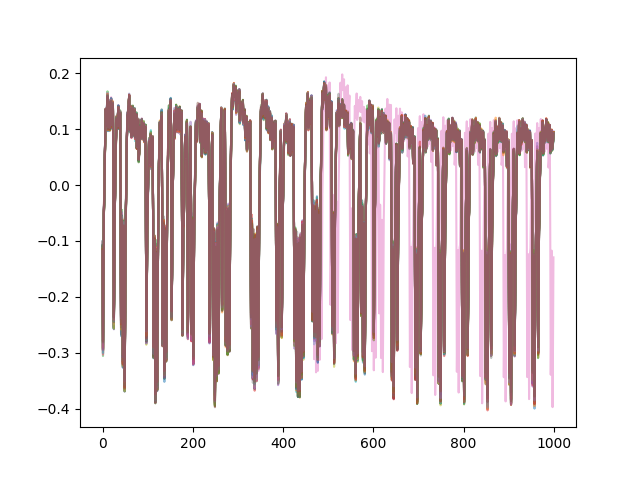

In [6]:
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl
"""
plt.figure()

LIST_OF_VALID_CHARACTERS: str = "abcdefghijklmnopqrstuvwxyz0123456789"
for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace("h" + CHARACTER + "\n")
    plt.plot(trace[:1000], alpha=0.5, label="h" + CHARACTER)

plt.legend()
plt.show()
"""
fig1, ax1 = plt.subplots()
LIST_OF_VALID_CHARACTERS: str = "abcdefghijklmnopqrstuvwxyz0123456789"
for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace("h" + CHARACTER + "\n")
    ax1.plot(trace[:1000], alpha=0.5, label="h" + CHARACTER)

mplcursors.cursor(ax1, hover=True)
plt.show()

Cependant, supposons de manière plus réaliste que nous n'ayons aucune information sur le vrai mot de passe en question. De quelle information disposons-nous néanmoins ? Il n'existe qu'un seul mot de passe valide. Autrement dit, il existe une unique entrée pour laquelle le traitement par le système sera totalement différent des autres, ce qui implique que la **trace de consommation** sera aussi drastiquement différente. 
Afin de détecter cette différence, posons comme trace de référence pour un mot de passe incorrect le mot de passe vide `\x01\n` et comme seuil de référence pour affirmer qu'un caractère est correct `25.0`. Il nous suffit ensuite de répéter cette analyse pour chaque caractère du mot de passe, et l'attaque sera totalement réussie ! 

In [8]:
from rich import print

THRESHOLD: float = 25.0
NULL_BYTE: str = "\x01"
password_length: int = 5
password_found: str = ""

for i in range(password_length):
    ref_trace = cap_pass_trace(password_found + "\x01\n") # trace de référence mdp incorrect
    current_diff: float = None
    character_found: str = ""

    for CHARACTER in LIST_OF_VALID_CHARACTERS: # teste tous les caractères possibles
        trace = cap_pass_trace(password_found + CHARACTER + "\n")
        diff = np.sum(np.abs(trace - ref_trace)) # évalue la différence avec la ref_trace incorrecte
        if current_diff == None:
            current_diff = diff
            character_found = CHARACTER
        elif diff > current_diff + THRESHOLD: # si la différence est supérieure au seuil de détection -> caractère trouvé !
            print(f":information: New character found: {password_found + CHARACTER} (previous diff: {current_diff} ({password_found + character_found}); current diff: {diff})")
            current_diff = diff
            character_found = CHARACTER

    password_found += character_found # on retient le caractère détecté ayant la plus grande différence
    print(f":key: Character {i+1} of the password: [blue]{character_found}[/blue] (diff: {current_diff}) (current password: {password_found})")

print(f":white_heavy_check_mark: The password is: [green]{password_found}[/green]")

ℹ New character found: h (previous diff: 8.2470703125 (a); current diff: 300.540283203125)

🔑 Character 1 of the password: h (diff: 300.540283203125) (current password: h)

ℹ New character found: h0 (previous diff: 7.8759765625 (ha); current diff: 297.25244140625)

🔑 Character 2 of the password: 0 (diff: 297.25244140625) (current password: h0)

ℹ New character found: h0p (previous diff: 7.848876953125 (h0a); current diff: 292.7880859375)

🔑 Character 3 of the password: p (diff: 292.7880859375) (current password: h0p)

ℹ New character found: h0px (previous diff: 8.59765625 (h0pa); current diff: 286.77734375)

🔑 Character 4 of the password: x (diff: 286.77734375) (current password: h0px)

ℹ New character found: h0px3 (previous diff: 8.46435546875 (h0pxa); current diff: 312.728759765625)

🔑 Character 5 of the password: 3 (diff: 312.728759765625) (current password: h0px3)

✅ The password is: h0px3

Bravo, le mot de passe totalement inconnu au départ de cette attaque *SPA* a été entièrement deviné, simplement en exploitant de façon visuelle le lien de **corrélation entre consommation électrique et opérations cryptographiques** !